**Data Source**  
https://www.kaggle.com/code/msripooja/hourly-energy-consumption-time-series-rnn-lstm/notebook

Meng-*import library* python yang dibutuhkan.

In [19]:
# Dataframe
import pandas as pd
import numpy as np

# Split Data
from sklearn.model_selection import train_test_split

# Preprocessing dan Layer
import sklearn.preprocessing
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Dropout
from sklearn.metrics import r2_score

# Visualisasi Plot
import matplotlib.pyplot as plt
from plotly import graph_objs as go

Membaca dan menampilkan dataset.

In [2]:
df = pd.read_csv('AEP_hourly.csv')
df

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


Melakukan pengecekan keberadaan *missing values* pada dataset

In [3]:
df.isnull().sum()

Datetime    0
AEP_MW      0
dtype: int64

Melakukan proses normalisasi terhadap dataset dengan menggunakan fungsi `MinMaxScaler()` guna mengubah nilai-nilai dari sebuah fitur ke dalam skala yang sama.

In [4]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['AEP_MW']=scaler.fit_transform(df['AEP_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(121273, 2)

Melakukan *plotting* grafik terhadap dataframe setelah normalisasi.

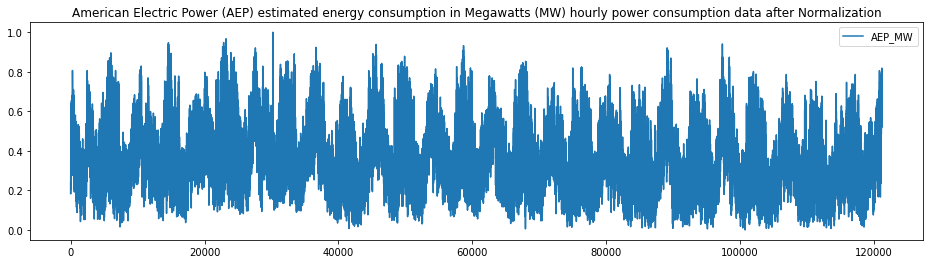

In [6]:
df_norm.plot(figsize=(16,4),legend=True)
plt.title('American Electric Power (AEP) estimated energy consumption in Megawatts (MW) hourly power consumption data after Normalization')
plt.show()

Melakukan pengecekan bentuk data.

In [7]:
df_norm.shape

(121273, 2)

Mengubah nilai-nilai pada dataframe ke dalam tipe data numpy array menggunakan atribut values agar data dapat diproses oleh model.

In [8]:
dates = df['Datetime'].values
aep = df['AEP_MW'].values

Melakukan pengecekan tipe data masing-masing kolom pada dataframe.

In [9]:
df.dtypes

Datetime     object
AEP_MW      float64
dtype: object

Membagi dataset menjadi train set dan validation set dengan ukuran masing-masing 80% dan 20%.

In [10]:
x_train, x_valid, y_train, y_valid = train_test_split(aep, dates, train_size=0.8, test_size=0.2, shuffle=False )

In [11]:
print('Total Data Train : ',len(x_train))
print('Total Data Validation : ',len(x_valid))

Total Data Train :  97018
Total Data Validation :  24255


Membuat fungsi `windowed_dataset` untuk menerima sebuah series/atribut kita yang telah di konversi menjadi tipe numpy, lalu mengembalikan label dan atribut dari dataset dalam bentuk batch.

In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

Membuat arsitektur model dengan menggunakan gunakan 2 buah layer `Bidirectional LSTM` yang dilengkapi dengan `dropout` guna mencegah *overfitting*. 

In [15]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=200, shuffle_buffer=1000)
val_set = windowed_dataset(x_valid, window_size=60, batch_size=200, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
                                    Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
                                    Bidirectional(tf.keras.layers.LSTM(60, dropout=0.2)),
                                    Dense(16, activation="relu"),
                                    Dropout(0.2),
                                    Dense(8, activation="relu"),
                                    Dense(1),
])

Melakukan pengecekan nilai MAE dari model < 10% skala data.

In [16]:
minMae = (df['AEP_MW'].max() - df['AEP_MW'].min()) * 10/100
print(minMae)

0.09999999999999998


In [17]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < minMae and logs.get('val_mae') < minMae):
      print("\MAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [24]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, validation_data=val_set, callbacks=[callbacks])

Epoch 1/100
485/485 [==============================] - 38s 52ms/step - loss: 0.0338 - mae: 0.2098 - val_loss: 0.0121 - val_mae: 0.1218
Epoch 2/100
485/485 [==============================] - 22s 44ms/step - loss: 0.0142 - mae: 0.1336 - val_loss: 0.0111 - val_mae: 0.1204
Epoch 3/100
485/485 [==============================] - 22s 45ms/step - loss: 0.0130 - mae: 0.1286 - val_loss: 0.0111 - val_mae: 0.1214
Epoch 4/100
485/485 [==============================] - 22s 45ms/step - loss: 0.0127 - mae: 0.1271 - val_loss: 0.0111 - val_mae: 0.1211
Epoch 5/100
485/485 [==============================] - 22s 45ms/step - loss: 0.0125 - mae: 0.1259 - val_loss: 0.0109 - val_mae: 0.1205
Epoch 6/100
485/485 [==============================] - 22s 45ms/step - loss: 0.0123 - mae: 0.1250 - val_loss: 0.0109 - val_mae: 0.1200
Epoch 7/100
485/485 [==============================] - 22s 45ms/step - loss: 0.0121 - mae: 0.1241 - val_loss: 0.0108 - val_mae: 0.1196
Epoch 8/100
485/485 [==============================] - 

Memvisualisasikan *history* model melalui plotting grafik mae dan loss guna mempermudah evaluasi model secara grafik dengan menggunakan *library* python `Matplotlib`.

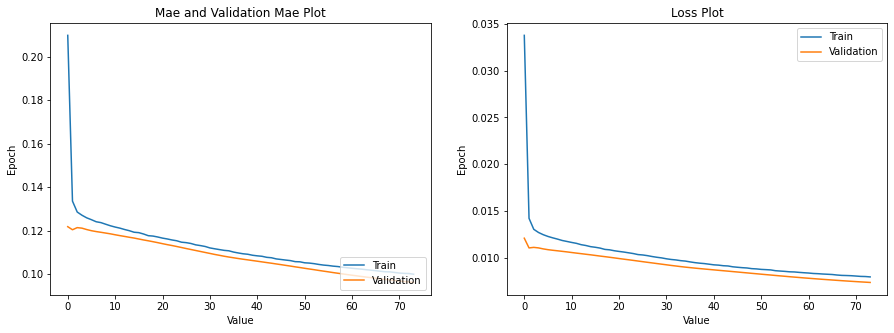

In [33]:
figure = plt.figure(figsize = (15, 5))

figure.add_subplot(1, 2, 1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mae and Validation Mae Plot')
plt.xlabel('Value')
plt.ylabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')

figure.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Plot')
plt.xlabel('Value')
plt.ylabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')

plt.show()